In [6]:
# Make plots in the notebook so you can see them.
%matplotlib inline

import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.optimize import curve_fit


In [12]:
# Set up needed methods

def Carter_model(time, tc, f0, delta, T, tau):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - f0*r**2
    # T - 2*tau0*sqrt(1-b**2)
    # tau = 2*tau0*r**2/sqrt(1 - b**2)

    flux = np.zeros_like(time)

    ind = np.abs(time - tc) <= (T/2. - tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta

    ind = ((T/2. - tau/2.) < np.abs(time - tc)) & ((T/2. + tau/2.) > np.abs(time - tc))
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta + (delta/tau)*(np.abs(time[ind] - tc) - T/2. + tau/2.)

    ind = np.abs(time - tc) >= (T/2. + tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0

    return flux

def calc_sigma(detrended_flux):
    # Use the standard deviation of all the data to estimate the uncertainty
    return np.ones_like(detrended_flux)*mad(detrended_flux)

def bin_flux(time, flux, binsize=120./86400.):
    binned_time = np.array([])
    binned_flux = np.array([])
    binned_err = np.array([])

    cur_point = np.min(time) + 0.5*binsize
    while(cur_point <= np.max(time) - 0.5*binsize):
        ind = np.abs(cur_point - time) < 0.5*binsize

        if(len(time[ind]) > 0):
            binned_time = np.append(binned_time, np.mean(time[ind]))
            binned_flux = np.append(binned_flux, np.mean(flux[ind]))
            binned_err = np.append(binned_err, np.std(flux[ind]))
        
        cur_point += binsize

    return binned_time, binned_flux, binned_err

def detrend_w_SavGol(sector_lc, epoch_0_BTJD, orbital_period):
    # The light curves have nans in them, so we need to remove those points.
    cur_time = np.array(sector_lc.time.value)
    cur_flux = np.array(sector_lc.flux.value)
    ind = ~np.isnan(cur_flux)
    cur_time = cur_time[ind]
    cur_flux = cur_flux[ind]

    # Mask out transit
    known_transit_mask = (sector_lc.remove_nans()).create_transit_mask(transit_time=epoch_0_BTJD, period=orbital_period, duration=0.1)
    
    # Detrend out binary signal
    binary_period = 2.*sector_lc.to_periodogram(oversample_factor=10).period_at_max_power
    time_folded_on_binary_period = cur_time % binary_period.value

    # Bin folded flux
    binned_time, binned_flux, binned_err = bin_flux(time_folded_on_binary_period[~known_transit_mask], cur_flux[~known_transit_mask])

    # Now interpolate across whole time-series unfolded
    interp_trend = np.interp(time_folded_on_binary_period, binned_time, binned_flux)

    detrended_flux = cur_flux / interp_trend
    plt.scatter(cur_time % orbital_period, detrended_flux, marker='.') 

    return cur_time, detrended_flux


def fit_transit_ephemeris(time, trial_T0, trial_period):
    # Phase fold on the trial period
    folded_time = ((time - trial_T0) % trial_period)
    
    ret_val = Carter_model(folded_time, trial_T0, *transit_shape_params[1:])
    
    return ret_val

In [10]:
# Define "global" variables
# From https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract
orbital_period = 2.79744256 #±0.00000041 
epoch_0 = 2457938.84392 # ±0.00016

# convert t0 to TESS BJD (BTJD)
epoch_0_BTJD = epoch_0 - 2457000.

LightCurveCollection of 11 objects:
    0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 267572272

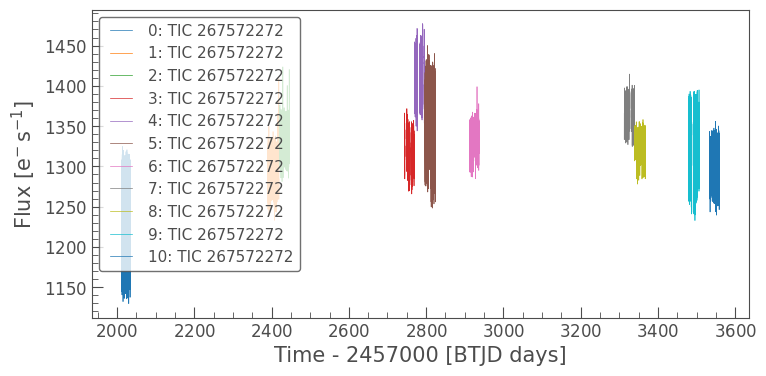

In [7]:
search_result = lk.search_lightcurve("TIC 267572272", author='SPOC', exptime='short')
search_result
tess_lc_collection = search_result.download_all()  # changed name of variable to make it easier to identify
print(tess_lc_collection)

for lc in tess_lc_collection:
    print("Sector ", lc.sector, "Crowdsap", lc.meta.get("CROWDSAP"), "flfrcsap", lc.meta.get("FLFRCSAP"))

tess_lc_collection.plot();

### Fitting the model
Now we'll try to fit transit times

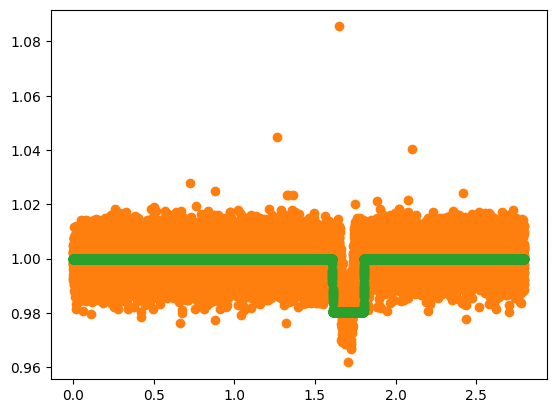

In [18]:
# Select the tess sector you want to fit to: (start with the second one (index 1))
full_lightcurve = tess_lc_collection[1]
time, detrended_flux = detrend_w_SavGol(full_lightcurve, epoch_0_BTJD, orbital_period)

# Phase-folded time
folded_time = (time % orbital_period)

# The background value is very nearly the median for all the data
background = np.median(detrended_flux)

# ratio of the planet's to the star's radius - usually about 0.1
ratio_of_planet_to_star_radius = 0.1394

# Let's guess that the central transit time is the time when the flux drops to its minimum value
t0 = (time % orbital_period)[np.argmin(detrended_flux)]

# transit duration - probably a few hours, but be sure to tweak it to what your eyeball says
duration = 2.33/24. # Divide through 24 hours to convert from hours to days.

# Let's set our initial guesses and check them
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius**2, 
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

plt.scatter(folded_time, detrended_flux)
plt.scatter(folded_time, Carter_model(folded_time, *initial_guesses))
# plt.xlim(1.5, 2.0)

best fit values: 1.69888, 1.00001, 0.0192435, 0.0768547, 0.0161488
best fit uncertainties: 0.000327448, 4.32671e-05, 0.000288119, 0.000698065, 0.00115753


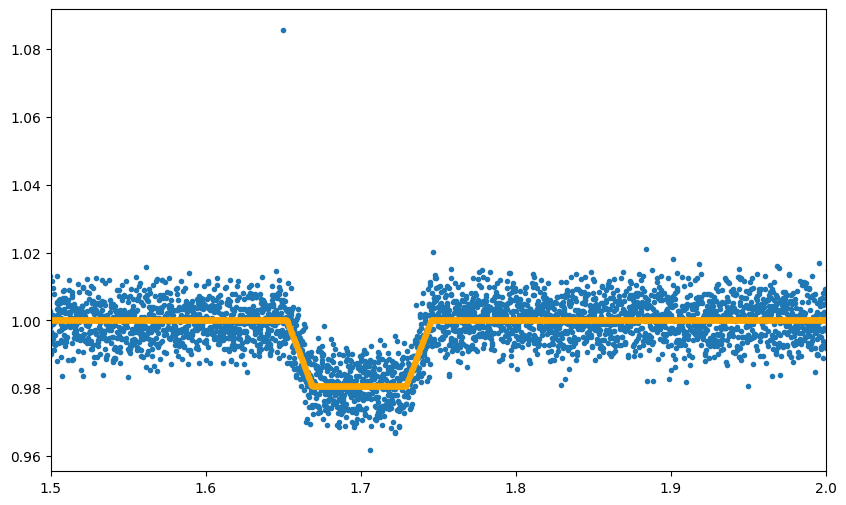

In [13]:
# Reset initial guesses
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius, 
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

# Estimate per-point uncertainties
sigma = calc_sigma(detrended_flux)

# Fit folded transit
transit_shape_params, pcov = curve_fit(Carter_model, folded_time, detrended_flux,
                      p0=initial_guesses, sigma=sigma)
transit_shape_params_unc = np.sqrt(np.diag(pcov))
print("best fit values: %g, %g, %g, %g, %g" %\
      (transit_shape_params[0], 
       transit_shape_params[1], 
       transit_shape_params[2],
       transit_shape_params[3], 
       transit_shape_params[4]))
print("best fit uncertainties: %g, %g, %g, %g, %g" % (transit_shape_params_unc[0], 
                                                      transit_shape_params_unc[1], 
                                                      transit_shape_params_unc[2], 
                                                      transit_shape_params_unc[3], 
                                                      transit_shape_params_unc[4]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Check the fit
ax.scatter(folded_time, detrended_flux, marker=".")
ax.scatter(folded_time, Carter_model(folded_time, *transit_shape_params), marker='.', color='orange')

x_label_text = "" # Label your x-axis
y_label_text = "" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)
plt.xlim(1.5, 2.0)

# Save your figure - use another name that describes the data plotted
figure_name = "figure.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

---

### Fitting the Ephemeris

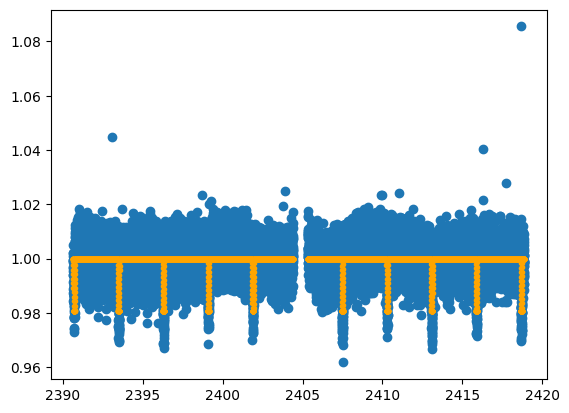

In [14]:
# Again let's set our initial guesses and check how they look
T0 = 0.5*transit_shape_params[0] # This number has to be VERY close to the right number.
ephemeris_initial_guesses = np.array([T0, orbital_period])
initial_guess_transits = fit_transit_ephemeris(time, *ephemeris_initial_guesses)

plt.scatter(time, detrended_flux)
plt.scatter(time, initial_guess_transits, color='orange', marker='.')

[0.84943916 2.79744256]
best fit T0, period: 0.851423, 2.79744
best fit T0, period unc: 0.00218616, 5.09475e-06


Text(0, 0.5, '')

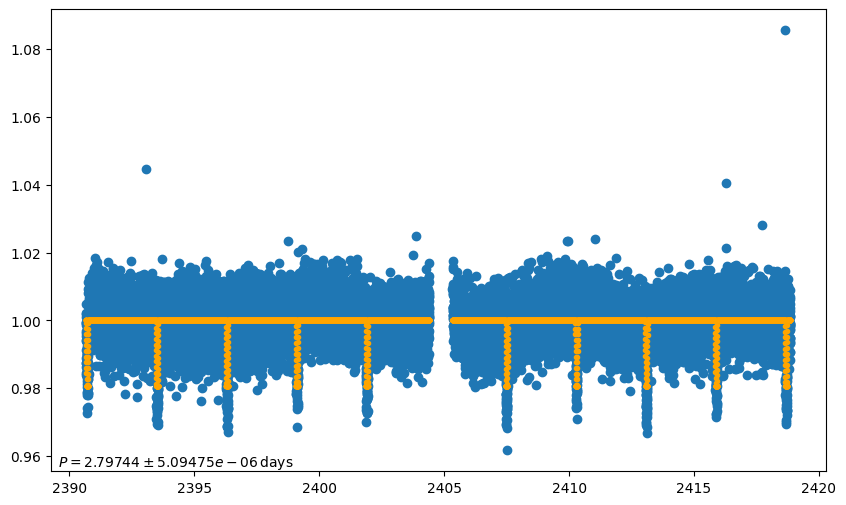

In [16]:
# Now let's do our fit.

ephemeris_fit_params, pcov = curve_fit(fit_transit_ephemeris, time, detrended_flux, 
                       p0=ephemeris_initial_guesses, sigma=sigma)
ephemeris_fit_params_unc = np.sqrt(np.diag(pcov))
print(ephemeris_initial_guesses)
print("best fit T0, period: %g, %g" % (ephemeris_fit_params[0], ephemeris_fit_params[1]))
print("best fit T0, period unc: %g, %g" % (ephemeris_fit_params_unc[0], ephemeris_fit_params_unc[1]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.scatter(time, detrended_flux)
ax.scatter(time, fit_transit_ephemeris(time, *ephemeris_fit_params), color='orange', marker='.')

# Include your final result on the figure
ax.text(0.01, 0.01, r'$P = %g\pm%g\,{\rm days}$' % (ephemeris_fit_params[1], ephemeris_fit_params_unc[1]), 
        transform=ax.transAxes)

x_label_text = "" # Label your x-axis
y_label_text = "" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)


# Save your figure - use another name that describes the data plotted
# figure_name = "figure.png"
# fig.savefig(figure_name, dpi=300, bbox_inches="tight")